<a href="https://colab.research.google.com/github/cristinarainich/Sternberg_analysis/blob/main/DF%20for%20neighbourhood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports and drive access

Updated on 17/05/2023 13:40

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import pylab as pl
import seaborn as sns
import re
from scipy import stats
import scipy.io
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
from scipy.stats import f_oneway
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import boxcox
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
sns.set()

In [12]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [13]:
!ls /content/gdrive/MyDrive/CoganLab/Neighbourhood

 D71_Block_1_TrialData.mat	  D84_Block_1_TrialData.mat
'D72_Block_1_TrialData (1).mat'   D85_Block_1_TrialData.mat
 D72_Block_1_TrialData.mat	  D86_Block_1_TrialData.mat
'D73_Block_1_TrialData (1).mat'   D87_Block_1_TrialData.mat
 D73_Block_1_TrialData.mat	  eeg_all.csv
 D77_Block_1_TrialData.mat	  eeg_processed.csv
 D79_Block_1_TrialData.mat	  ieeg_all.csv
 D80_Block_1_TrialData.mat	  ieeg_processed.csv
 D81_Block_1_TrialData.mat	  Subject_NeighborhoodSternberg_EEG_060322.mat
 D82_Block_1_TrialData.mat	  Subject_NeighborhoodSternberg_IEEG_060322.mat


In [10]:
working_path = Path('/content/gdrive/MyDrive/CoganLab/Neighbourhood')

In [14]:
# controls' data
eeg = scipy.io.loadmat(
    working_path.joinpath('Subject_NeighborhoodSternberg_EEG_060322.mat')
    )
# patients' data
ieeg = scipy.io.loadmat(
    working_path.joinpath('Subject_NeighborhoodSternberg_IEEG_060322.mat')
    )
new_subject72 = scipy.io.loadmat(
    working_path.joinpath('D72_Block_1_TrialData.mat')
    )
new_subject73 = scipy.io.loadmat(
    working_path.joinpath('D73_Block_1_TrialData.mat')
    )
new_subject77 = scipy.io.loadmat(
    working_path.joinpath('D77_Block_1_TrialData.mat')
    )
new_subject79 = scipy.io.loadmat(
    working_path.joinpath('D79_Block_1_TrialData.mat')
    )
new_subject80 = scipy.io.loadmat(
    working_path.joinpath('D80_Block_1_TrialData.mat')
    )
new_subject81 = scipy.io.loadmat(
    working_path.joinpath('D81_Block_1_TrialData.mat')
    )
new_subject82 = scipy.io.loadmat(
    working_path.joinpath('D82_Block_1_TrialData.mat')
    )
new_subject84 = scipy.io.loadmat(
    working_path.joinpath('D84_Block_1_TrialData.mat')
    )
new_subject85 = scipy.io.loadmat(
    working_path.joinpath('D85_Block_1_TrialData.mat')
    )
new_subject85 = scipy.io.loadmat(
    working_path.joinpath('D85_Block_1_TrialData.mat')
    )
new_subject86 = scipy.io.loadmat(
    working_path.joinpath('D86_Block_1_TrialData.mat')
    )
new_subject87 = scipy.io.loadmat(
    working_path.joinpath('D87_Block_1_TrialData.mat')
    )

# iEEG dataset 

In [15]:
data_ieeg = ieeg['Subject'] # contains trials for each of the subjects
print('Number of subjects in EEG dataset is', data_ieeg.shape[1])

Number of subjects in EEG dataset is 30


In [16]:
subjects_ieeg = [] # subject numbers
for i in data_ieeg['Name'][0]:
  subjects_ieeg.append(i[0])

In [17]:
def get_to_df(data):
  # this function reads into .mat file and creates df out of it for all of the trials of one subject
  # i'm planning on making it more beautiful later

  columns = data[0][1].dtype.names
  df = pd.DataFrame(columns=columns)
  df['Trial'] = np.nan
  df_ = df.copy()
  for i in range(0, data.shape[1]): # for each trial number
    mdtype = data[0][i].dtype
    values = []
    for name in mdtype.names:
      values.append(data[0][i][name])
    values = extra_arrays(values)
    values.append(str(i)) # adding a trial number at the end
    df_.loc[len(df_.index)] = values
  return df_

In [18]:
def extra_arrays(x):
  # elements have nested structure, i.e. arrays inside the arrays
  # below we're getting rid of this depending on the shape of values

  values = []
  for elem in range(0, len(x)):
    var = x[elem]
    var = var[0, 0]
    if var.shape == (1, 1):
      var = var[0, 0]
      values.append(var)
    elif var.shape == (1,):
      values.append(var[0])
    elif var.shape == (1, 5):
      var = var.tolist()[0]
      values.append(var)
    elif var.shape == (5, 1):
      new = []
      for i in var:
        i = i[0]
        new.append(i)
      values.append(new)
    else:
      values.append(var)
  return values

In [19]:
columns_ieeg = data_ieeg['trialInfo'][0, 0][0, 0].dtype.names # name of the variables from trial info
final_ieeg = pd.DataFrame(columns=columns_ieeg)
final_ieeg['Trial'] = np.nan
final_ieeg['Subject'] = np.nan
for subj in range(0, data_ieeg['trialInfo'].shape[1]): # for each subject
  print(subj)
  subj_df = get_to_df(data_ieeg['trialInfo'][0, subj])
  subj_df['Subject'] = subjects_ieeg[subj]
  final_ieeg = pd.concat([final_ieeg, subj_df], axis = 0)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [20]:
# additional subjects
d72 = get_to_df(new_subject72['trialInfo'])
d73 = get_to_df(new_subject73['trialInfo'])
d77 = get_to_df(new_subject77['trialInfo'])
d79 = get_to_df(new_subject79['trialInfo'])
d80 = get_to_df(new_subject80['trialInfo'])
d81 = get_to_df(new_subject81['trialInfo'])
d82 = get_to_df(new_subject82['trialInfo'])
d84 = get_to_df(new_subject84['trialInfo'])
d85 = get_to_df(new_subject85['trialInfo'])
d86 = get_to_df(new_subject86['trialInfo'])
d87 = get_to_df(new_subject87['trialInfo'])

In [21]:
d72['Subject'] = 'D72'
d73['Subject'] = 'D73'
d77['Subject'] = 'D77'
d79['Subject'] = 'D79'
d80['Subject'] = 'D80'
d81['Subject'] = 'D81'
d82['Subject'] = 'D82'
d84['Subject'] = 'D84'
d85['Subject'] = 'D85'
d86['Subject'] = 'D86'
d87['Subject'] = 'D87'

In [22]:
ieeg = pd.concat([final_ieeg, d72])
ieeg = pd.concat([ieeg, d73])
ieeg = pd.concat([ieeg, d77])
ieeg = pd.concat([ieeg, d79])
ieeg = pd.concat([ieeg, d80])
ieeg = pd.concat([ieeg, d81])
ieeg = pd.concat([ieeg, d82])
ieeg = pd.concat([ieeg, d84])
ieeg = pd.concat([ieeg, d85])
ieeg = pd.concat([ieeg, d86])
ieeg = pd.concat([ieeg, d87])

In [23]:
len(ieeg.Subject.unique())

41

In [24]:
ieeg.Subject.unique()

array(['D23', 'D26', 'D27', 'D28', 'D29', 'D30', 'D31', 'D33', 'D34',
       'D35', 'D36', 'D38', 'D39', 'D41', 'D42', 'D47', 'D48', 'D49',
       'D53', 'D54', 'D55', 'D57', 'D59', 'D61', 'D63', 'D65', 'D68',
       'D69', 'D70', 'D71', 'D72', 'D73', 'D77', 'D79', 'D80', 'D81',
       'D82', 'D84', 'D85', 'D86', 'D87'], dtype=object)

In [25]:
# saving only ieeg dataset anew
ieeg.to_csv(
    Path(working_path).joinpath('ieeg_all.csv')
)

#Preprocessing iEEG dataset

In [ ]:
#ieeg = ieeg.loc[:, ieeg.columns != 'Unnamed: 0'] # some extra column appeared while uploading data

In [26]:
ieeg.isnull().sum()

block                       0
ProbeType                   0
ProbeTypeName               0
StimlusCategory             0
ReactionTime                0
KeyCode                     0
Resp                        0
RespCorrect                 0
Omission                  160
stimulusAudioStart          0
stimulusAlignedTrigger      0
probeAudioStart             0
probeAlignedTrigger         0
TriggerValue                0
stimulusSounds_idx          0
stimulusSounds_name         0
ProbeCategory               0
probeSound_idx              0
probeSound_name             0
Trial                       0
Subject                     0
ListenCueTime             953
MaintenancePeriodTime     953
ProbeCueTime              953
dtype: int64

In [27]:
ieeg.shape

(6580, 24)

In [28]:
ieeg.Subject.unique()

array(['D23', 'D26', 'D27', 'D28', 'D29', 'D30', 'D31', 'D33', 'D34',
       'D35', 'D36', 'D38', 'D39', 'D41', 'D42', 'D47', 'D48', 'D49',
       'D53', 'D54', 'D55', 'D57', 'D59', 'D61', 'D63', 'D65', 'D68',
       'D69', 'D70', 'D71', 'D72', 'D73', 'D77', 'D79', 'D80', 'D81',
       'D82', 'D84', 'D85', 'D86', 'D87'], dtype=object)

In [29]:
ieeg.columns

Index(['block', 'ProbeType', 'ProbeTypeName', 'StimlusCategory',
       'ReactionTime', 'KeyCode', 'Resp', 'RespCorrect', 'Omission',
       'stimulusAudioStart', 'stimulusAlignedTrigger', 'probeAudioStart',
       'probeAlignedTrigger', 'TriggerValue', 'stimulusSounds_idx',
       'stimulusSounds_name', 'ProbeCategory', 'probeSound_idx',
       'probeSound_name', 'Trial', 'Subject', 'ListenCueTime',
       'MaintenancePeriodTime', 'ProbeCueTime'],
      dtype='object')

In [30]:
ieeg_subset = ieeg[[
                 'Trial', 'Subject', 'block', 'ProbeType', 'probeSound_idx',
                 'ProbeTypeName', 'StimlusCategory', 'ReactionTime', 'KeyCode',
                 'Resp', 'RespCorrect', 'Omission', 'ProbeCategory',
                  'stimulusSounds_idx', 'stimulusSounds_name', 'probeSound_name'              
]]

In [31]:
ieeg_subset.head()

,Trial,Subject,block,ProbeType,probeSound_idx,ProbeTypeName,StimlusCategory,ReactionTime,KeyCode,Resp,RespCorrect,Omission,ProbeCategory,stimulusSounds_idx,stimulusSounds_name,probeSound_name
0,0,D23,1,2,29,in_sequence,Low Words,0.857518,37,Yes,1,Responded,Low Words,"[[29, 25, 30]]","[[[wash.wav]], [[sure.wav]], [[youth.wav]]]",wash.wav
1,1,D23,1,2,5,in_sequence,High Words,1.339604,37,Yes,1,Responded,High Words,"[[2, 5, 8, 4, 7, 10, 3]]","[[[debt.wav]], [[lair.wav]], [[seek.wav]], [[g...",lair.wav
2,2,D23,1,2,16,in_sequence,High Non-Words,1.045657,37,Yes,1,Responded,High Non-Words,"[[19, 14, 18, 16, 20, 15, 17]]","[[[rihn.wav]], [[kehl.wav]], [[rehl.wav]], [[p...",paon.wav
3,3,D23,1,1,29,out_of_sequence,High Words,1.497001,39,No,1,Responded,Low Words,"[[10, 2, 7, 9, 1, 8, 6, 5, 4]]","[[[witch.wav]], [[debt.wav]], [[pawn.wav]], [[...",wash.wav
4,4,D23,1,1,9,out_of_sequence,Low Words,1.679783,39,No,1,Responded,High Words,"[30, 24, 25, 29, 21]","[[youth.wav], [noun.wav], [sure.wav], [wash.wa...",soar.wav


In [32]:
# check if any of the subjects is less than 75 % accurate
checkset = ieeg_subset.groupby(['Subject'])[['RespCorrect']].apply(
    lambda x: x.sum()/x.count()
)
(checkset < 0.75).any()

RespCorrect    True
dtype: bool

In [34]:
ieeg_subset[ieeg_subset['Resp'] == 'No Response']

,Trial,Subject,block,ProbeType,probeSound_idx,ProbeTypeName,StimlusCategory,ReactionTime,KeyCode,Resp,RespCorrect,Omission,ProbeCategory,stimulusSounds_idx,stimulusSounds_name,probeSound_name
9,9,D23,1,2,39,in_sequence,Low Non-words,2.502478,"[[37, 39, 32, 27]]",No Response,0,No Response,Low Non-words,"[[32, 37, 31, 39, 40, 35, 33, 38, 36]]","[[[faez.wav]], [[wehz.wav]], [[deech.wav]], [[...",yuwf.wav
19,19,D23,1,1,40,out_of_sequence,High Non-Words,2.502283,"[[37, 39, 32, 27]]",No Response,0,No Response,Low Non-Words,"[[17, 19, 18, 13, 15, 12, 16]]","[[[puwn.wav]], [[rihn.wav]], [[rehl.wav]], [[k...",zerth.wav
26,26,D23,1,1,33,out_of_sequence,High Non-Words,2.502340,"[[37, 39, 32, 27]]",No Response,0,No Response,Low Non-Words,"[[13, 18, 14]]","[[[kawl.wav]], [[rehl.wav]], [[kehl.wav]]]",gawth.wav
32,32,D23,2,2,25,in_sequence,Low Words,2.502395,"[[37, 39, 32, 27]]",No Response,0,No Response,Low Words,"[[30, 22, 25, 29, 21, 23, 24, 28, 27]]","[[[youth.wav]], [[fudge.wav]], [[sure.wav]], [...",sure.wav
97,97,D23,4,1,36,out_of_sequence,High Non-Words,2.502652,"[[37, 39, 32, 27]]",No Response,0,No Response,Low Non-Words,"[[16, 17, 18]]","[[[paon.wav]], [[puwn.wav]], [[rehl.wav]]]",vern.wav
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,93,D86,3,1,34,out_of_sequence,High Non-Words,2.501463,"[114, 115, 66, 10, 27]",No Response,0,No Response,Low Non-Words,"[[17, 19, 16, 15, 18, 20, 12]]","[[[puwn.wav]], [[rihn.wav]], [[paon.wav]], [[k...",jhong.wav
101,101,D86,4,2,8,in_sequence,High Words,2.501425,"[114, 115, 66, 10, 27]",No Response,0,No Response,High Words,"[[8, 7, 4, 9, 2, 5, 6]]","[[[seek.wav]], [[pawn.wav]], [[gear.wav]], [[s...",seek.wav
102,102,D86,4,2,21,in_sequence,Low Words,2.502047,"[114, 115, 66, 10, 27]",No Response,0,No Response,Low Words,"[[21, 26, 28, 23, 24, 22, 27, 29, 25]]","[[[fog.wav]], [[toss.wav]], [[waif.wav]], [[lo...",fog.wav
112,112,D86,4,1,27,out_of_sequence,High Words,2.501451,"[114, 115, 66, 10, 27]",No Response,0,No Response,Low Words,"[7, 10, 4, 2, 6]","[[pawn.wav], [witch.wav], [gear.wav], [debt.wa...",tube.wav


In [35]:
ieeg_subset[ieeg_subset['Omission'] != 'Responded']
# let's keep these NaNs since all the other information is there 

,Trial,Subject,block,ProbeType,probeSound_idx,ProbeTypeName,StimlusCategory,ReactionTime,KeyCode,Resp,RespCorrect,Omission,ProbeCategory,stimulusSounds_idx,stimulusSounds_name,probeSound_name
9,9,D23,1,2,39,in_sequence,Low Non-words,2.502478,"[[37, 39, 32, 27]]",No Response,0,No Response,Low Non-words,"[[32, 37, 31, 39, 40, 35, 33, 38, 36]]","[[[faez.wav]], [[wehz.wav]], [[deech.wav]], [[...",yuwf.wav
19,19,D23,1,1,40,out_of_sequence,High Non-Words,2.502283,"[[37, 39, 32, 27]]",No Response,0,No Response,Low Non-Words,"[[17, 19, 18, 13, 15, 12, 16]]","[[[puwn.wav]], [[rihn.wav]], [[rehl.wav]], [[k...",zerth.wav
26,26,D23,1,1,33,out_of_sequence,High Non-Words,2.502340,"[[37, 39, 32, 27]]",No Response,0,No Response,Low Non-Words,"[[13, 18, 14]]","[[[kawl.wav]], [[rehl.wav]], [[kehl.wav]]]",gawth.wav
32,32,D23,2,2,25,in_sequence,Low Words,2.502395,"[[37, 39, 32, 27]]",No Response,0,No Response,Low Words,"[[30, 22, 25, 29, 21, 23, 24, 28, 27]]","[[[youth.wav]], [[fudge.wav]], [[sure.wav]], [...",sure.wav
97,97,D23,4,1,36,out_of_sequence,High Non-Words,2.502652,"[[37, 39, 32, 27]]",No Response,0,No Response,Low Non-Words,"[[16, 17, 18]]","[[[paon.wav]], [[puwn.wav]], [[rehl.wav]]]",vern.wav
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,93,D86,3,1,34,out_of_sequence,High Non-Words,2.501463,"[114, 115, 66, 10, 27]",No Response,0,No Response,Low Non-Words,"[[17, 19, 16, 15, 18, 20, 12]]","[[[puwn.wav]], [[rihn.wav]], [[paon.wav]], [[k...",jhong.wav
101,101,D86,4,2,8,in_sequence,High Words,2.501425,"[114, 115, 66, 10, 27]",No Response,0,No Response,High Words,"[[8, 7, 4, 9, 2, 5, 6]]","[[[seek.wav]], [[pawn.wav]], [[gear.wav]], [[s...",seek.wav
102,102,D86,4,2,21,in_sequence,Low Words,2.502047,"[114, 115, 66, 10, 27]",No Response,0,No Response,Low Words,"[[21, 26, 28, 23, 24, 22, 27, 29, 25]]","[[[fog.wav]], [[toss.wav]], [[waif.wav]], [[lo...",fog.wav
112,112,D86,4,1,27,out_of_sequence,High Words,2.501451,"[114, 115, 66, 10, 27]",No Response,0,No Response,Low Words,"[7, 10, 4, 2, 6]","[[pawn.wav], [witch.wav], [gear.wav], [debt.wa...",tube.wav


In [36]:
print(ieeg_subset[ieeg_subset['Omission'] != 'Responded'].Subject.unique())

['D23' 'D26' 'D27' 'D28' 'D30' 'D31' 'D33' 'D34' 'D35' 'D36' 'D38' 'D39'
 'D41' 'D42' 'D47' 'D48' 'D49' 'D53' 'D54' 'D55' 'D57' 'D59' 'D61' 'D63'
 'D65' 'D68' 'D69' 'D70' 'D71' 'D72' 'D73' 'D77' 'D79' 'D84' 'D85' 'D86']


Creating additional variables

In [37]:
# types in ProbeCategory column differ in case
# here we make them lowrcase
new_probe = []
for i in ieeg_subset.ProbeCategory.values:
  new_probe.append(i.lower())
ieeg_subset['ProbeCategory'] = new_probe

<ipython-input-37-df1cb0339cf5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ieeg_subset['ProbeCategory'] = new_probe


In [38]:
ieeg_subset.head()

,Trial,Subject,block,ProbeType,probeSound_idx,ProbeTypeName,StimlusCategory,ReactionTime,KeyCode,Resp,RespCorrect,Omission,ProbeCategory,stimulusSounds_idx,stimulusSounds_name,probeSound_name
0,0,D23,1,2,29,in_sequence,Low Words,0.857518,37,Yes,1,Responded,low words,"[[29, 25, 30]]","[[[wash.wav]], [[sure.wav]], [[youth.wav]]]",wash.wav
1,1,D23,1,2,5,in_sequence,High Words,1.339604,37,Yes,1,Responded,high words,"[[2, 5, 8, 4, 7, 10, 3]]","[[[debt.wav]], [[lair.wav]], [[seek.wav]], [[g...",lair.wav
2,2,D23,1,2,16,in_sequence,High Non-Words,1.045657,37,Yes,1,Responded,high non-words,"[[19, 14, 18, 16, 20, 15, 17]]","[[[rihn.wav]], [[kehl.wav]], [[rehl.wav]], [[p...",paon.wav
3,3,D23,1,1,29,out_of_sequence,High Words,1.497001,39,No,1,Responded,low words,"[[10, 2, 7, 9, 1, 8, 6, 5, 4]]","[[[witch.wav]], [[debt.wav]], [[pawn.wav]], [[...",wash.wav
4,4,D23,1,1,9,out_of_sequence,Low Words,1.679783,39,No,1,Responded,high words,"[30, 24, 25, 29, 21]","[[youth.wav], [noun.wav], [sure.wav], [wash.wa...",soar.wav


In [39]:
# making values in df more 'handy'
whole_list = ieeg_subset['stimulusSounds_idx'].values
new_sound_idx = []
for i in whole_list:
  if type(i) is list:
    new_sound_idx.append(i)
  elif type(i) is np.ndarray:
    new_sound_idx.append(i[0].tolist())
  else:
    print(type(i))
    print(len(new_sound_idx))
    break

In [40]:
ieeg_subset['stimulusSounds_idx'] = new_sound_idx

<ipython-input-40-23db4ade8c7c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ieeg_subset['stimulusSounds_idx'] = new_sound_idx


In [41]:
# checking the length of word lists presented
compare = []
for i in new_sound_idx:
  length = len(i)
  if length not in compare:
    compare.append(length)
print(compare)

[3, 7, 9, 5]


In [42]:
# calculating relative position of the word in the list
# pos for only in seqence trials: probe sound index and stimulus sound index
# beginning middle or end
positions = [] # for the new 'position' column in df
# 1 - beginning, 2 - middle, 3 - end
ind = ieeg_subset['probeSound_idx'].values
in_out = ieeg_subset['ProbeTypeName'].values
for i in range(0, len(ind)):
  if in_out[i] == 'in_sequence': # if it is in sequence
    if ind[i] in new_sound_idx[i]:
      # for length of the list 3
      if len(new_sound_idx[i]) == 3:
        if new_sound_idx[i].index(ind[i]) == 0:
          positions.append(1) # beginning 
        elif new_sound_idx[i].index(ind[i]) == 1:
          positions.append(2) # middle
        elif new_sound_idx[i].index(ind[i]) == 2:
          positions.append(3) # end
      
      # for length of the list 5
      ## revise!
      elif len(new_sound_idx[i]) == 5:
        if new_sound_idx[i].index(ind[i]) in [0, 1]:
          positions.append(1) # beginning 
        elif new_sound_idx[i].index(ind[i]) == 2:
          positions.append(2) # middle
        elif new_sound_idx[i].index(ind[i]) in [3, 4]:
          positions.append(3) # end

      # for length of the list 7
      elif len(new_sound_idx[i]) == 7:
        if new_sound_idx[i].index(ind[i]) in [0, 1]:
          positions.append(1) # beginning 
        elif new_sound_idx[i].index(ind[i]) in [2, 3, 4]:
          positions.append(2) # middle
        elif new_sound_idx[i].index(ind[i]) in [5, 6]:
          positions.append(3) # end
      
      # for length of the list 9
      elif len(new_sound_idx[i]) == 9:
        if new_sound_idx[i].index(ind[i]) in [0, 1, 2]:
          positions.append(1) # beginning 
        elif new_sound_idx[i].index(ind[i]) in [3, 4, 5]:
          positions.append(2) # middle
        elif new_sound_idx[i].index(ind[i]) in [6, 7, 8]:
          positions.append(3) # end
    else:
      print('Check', i)
      break  
  elif in_out[i] == 'out_of_sequence':
    positions.append(0) # if it is out of sequence it is not in the list
  else:
    print('Check', i)
    break

In [43]:
length = []
for i in ieeg_subset.stimulusSounds_idx:
  length.append(len(i))

In [44]:
ieeg_subset['Position'] = positions
ieeg_subset['Length'] = length

<ipython-input-44-b7de9913c462>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ieeg_subset['Position'] = positions
<ipython-input-44-b7de9913c462>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ieeg_subset['Length'] = length


In [45]:
ieeg_subset.Length.unique()

array([3, 7, 9, 5])

In [46]:
lex = []
phon = []
for i in ieeg_subset.ProbeCategory.values:
  if 'non-words' in i: # non - words = 0, words = 0
    lex.append(0)
  elif 'words' in i:
    lex.append(1)
for i in ieeg_subset.ProbeCategory.values:
  if 'low' in i: # high = 0 low = 1 
    phon.append(1)
  elif 'high' in i:
    phon.append(0)
print(len(lex))
print(len(phon))

6580
6580


In [47]:
ieeg_subset['Lex'] = lex
ieeg_subset['Phono'] = phon

<ipython-input-47-aefbe34290ea>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ieeg_subset['Lex'] = lex
<ipython-input-47-aefbe34290ea>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ieeg_subset['Phono'] = phon


## Stats on iEEG

In [48]:
print('The shape of the iEEG dataset with "No Response" trials', ieeg_subset.shape)
print('The accuracy', ieeg_subset.RespCorrect.mean())
print('The shape of the iEEG dataset without "No Response" trials', ieeg_subset[ieeg_subset['Resp'] != 'No Response'].shape)
print('The accuracy', ieeg_subset[ieeg_subset['Resp'] != 'No Response'].RespCorrect.mean())

The shape of the iEEG dataset with "No Response" trials (6580, 20)
The accuracy 0.788145896656535
The shape of the iEEG dataset without "No Response" trials (6331, 20)
The accuracy 0.8191438951192545


In [49]:
checkset = ieeg_subset.groupby(['Subject'])[['RespCorrect']].apply(
    lambda x: x.sum()/x.count()
)

In [50]:
checkset

,RespCorrect
Subject,
D23,0.793750
D26,0.937500
D27,0.800000
D28,0.816993
D29,0.937500
D30,0.706250
D31,0.837500
D33,0.631016
D34,0.793750


In [51]:
options_drop1 = checkset[checkset['RespCorrect'] < 0.75].index
new1 = checkset.reset_index()
print('The subjects with accuracy less than 75 %')
print('The dataset with "No response" trials')
print(options_drop1)
x1 = []
for i in new1.Subject.values:
  for j in options_drop1:
    if i == j:
      x1.append(new1.loc[new1['Subject'] == i][['RespCorrect']].values[0][0])
print(x1)
ieeg1 = ieeg_subset[
                        (ieeg_subset['Subject'] != 'D30') &
                        (ieeg_subset['Subject'] != 'D33') &
                        (ieeg_subset['Subject'] != 'D49') &
                        (ieeg_subset['Subject'] != 'D54') &
                        (ieeg_subset['Subject'] != 'D61') &
                        (ieeg_subset['Subject'] != 'D65') &
                        (ieeg_subset['Subject'] != 'D70') &
                        (ieeg_subset['Subject'] != 'D77') & 
                        (ieeg_subset['Subject'] != 'D85')
                        ]
print('Poor performers', len(options_drop1))
print('Accuracy without poor performers', ieeg1.RespCorrect.mean())
print('')
options_drop1 = checkset[checkset['RespCorrect'] < 0.70].index
new2 = checkset.reset_index()
print('The subjects with accuracy less than 70 %')
print('The dataset with "No response" trials')
print(options_drop1)
x1 = []
for i in new2.Subject.values:
  for j in options_drop1:
    if i == j:
      x1.append(new2.loc[new2['Subject'] == i][['RespCorrect']].values[0][0])
print(x1)
ieeg2 = ieeg_subset[
                        (ieeg_subset['Subject'] != 'D33') &
                        (ieeg_subset['Subject'] != 'D49') &
                        (ieeg_subset['Subject'] != 'D54') &
                        (ieeg_subset['Subject'] != 'D61') &
                        (ieeg_subset['Subject'] != 'D65') & 
                        (ieeg_subset['Subject'] != 'D85')                   
                        ]
print('Poor performers', len(options_drop1))
print('Accuracy without poor performers', ieeg2.RespCorrect.mean())
print('')

The subjects with accuracy less than 75 %
The dataset with "No response" trials
Index(['D30', 'D33', 'D49', 'D54', 'D61', 'D65', 'D70', 'D77', 'D85'], dtype='object', name='Subject')
[0.70625, 0.6310160427807486, 0.61875, 0.43125, 0.6125, 0.65, 0.71875, 0.725, 0.65]
Poor performers 9
Accuracy without poor performers 0.8312145511441423

The subjects with accuracy less than 70 %
The dataset with "No response" trials
Index(['D33', 'D49', 'D54', 'D61', 'D65', 'D85'], dtype='object', name='Subject')
[0.6310160427807486, 0.61875, 0.43125, 0.6125, 0.65, 0.65]
Poor performers 6
Accuracy without poor performers 0.8213838726980154



In [52]:
ieeg2.shape

(5593, 20)

In [53]:
print(
    'No response trials in the dataset: ',
    ieeg2[ieeg2['Resp'] == 'No Response'].shape[0]
)

No response trials in the dataset:  125


Looking into outliers

<ipython-input-54-326f1ea5e14f>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ieeg2[ieeg2['Resp'] != 'No Response'][['ReactionTime']].values);


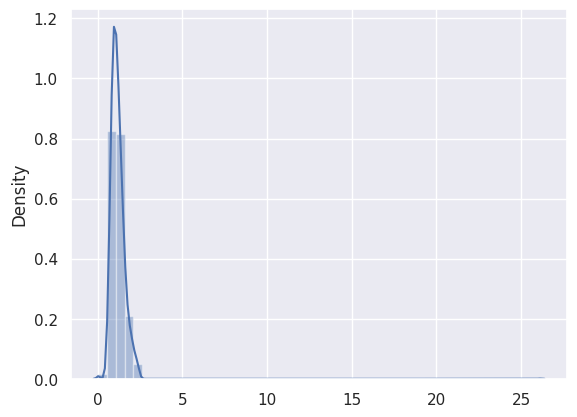

In [54]:
sns.distplot(ieeg2[ieeg2['Resp'] != 'No Response'][['ReactionTime']].values);

In [55]:
print('In seconds')
print(
    'mean', ieeg2[ieeg2['Resp'] != 'No Response'].ReactionTime.mean(),
    'max', ieeg2[ieeg2['Resp'] != 'No Response'].ReactionTime.max(),
    'min', ieeg2[ieeg2['Resp'] != 'No Response'].ReactionTime.min())

In seconds
mean 1.1780491927416907 max 26.115354993380606 min 0.016132116317749023


In [57]:
# kicking out all the trials (13) that are below 150 msec, two of the are no response trials
ieeg_no_outliers = ieeg2[ieeg2['ReactionTime'] > 0.15]

In [58]:
# kicking out the trial of 26 sec, only 1 
ieeg_no_outliers = ieeg_no_outliers[ieeg_no_outliers['ReactionTime'] < 25]

<ipython-input-59-279b2c087aca>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ieeg_no_outliers[ieeg_no_outliers['Resp'] != 'No Response'].ReactionTime)


Mean 1.1759843965064507 Max 2.4904961585998535 Min 0.33149156073341146


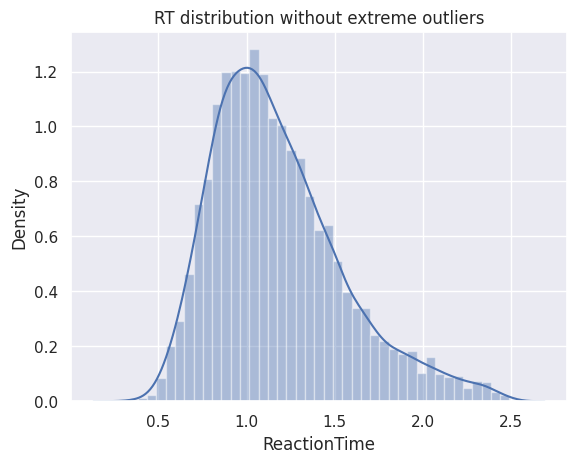

In [59]:
sns.distplot(ieeg_no_outliers[ieeg_no_outliers['Resp'] != 'No Response'].ReactionTime)
pl.title('RT distribution without extreme outliers');
print(
    'Mean', ieeg_no_outliers[ieeg_no_outliers['Resp'] != 'No Response'].ReactionTime.mean(),
    'Max', ieeg_no_outliers[ieeg_no_outliers['Resp'] != 'No Response'].ReactionTime.max(),
    'Min', ieeg_no_outliers[ieeg_no_outliers['Resp'] != 'No Response'].ReactionTime.min()
)

In [ ]:
values = []
for i in ieeg_no_outliers.Subject.unique():
  subset = ieeg_no_outliers[ieeg_no_outliers['Subject'] == i]
  q75 = np.percentile(subset[subset['Resp'] != 'No Response']['ReactionTime'], 75)
  q25 = np.percentile(subset[subset['Resp'] != 'No Response']['ReactionTime'], 25)
  inter_qr = q75 - q25
  upper = q75 + (inter_qr*3)
  lower = q25 - (inter_qr*3)
  index = 0
  for val in subset[subset['Resp'] != 'No Response'].ReactionTime.values:
    if val < lower:
      values.append((i, val))
      index += 1
    elif val > upper:
      values.append((i, val))
      index += 1
  print(i, index)

D23 0
D26 2
D27 3
D28 0
D29 3
D30 2
D31 0
D34 2
D35 1
D36 0
D38 3
D39 2
D41 0
D42 0
D47 0
D48 3
D53 0
D55 2
D57 0
D59 0
D63 0
D68 1
D69 0
D70 0
D71 3
D72 0
D73 0
D77 0
D79 0
D80 1
D81 0
D82 0
D84 0


In [ ]:
len(values)

28

In [60]:
print(shapiro(ieeg_no_outliers[ieeg_no_outliers['Resp'] != 'No Response']['ReactionTime'].values))
print(normaltest(ieeg_no_outliers[ieeg_no_outliers['Resp'] != 'No Response']['ReactionTime'].values))

ShapiroResult(statistic=0.9515177607536316, pvalue=3.7552584792331464e-39)
NormaltestResult(statistic=580.7397777213583, pvalue=7.833566903962933e-127)


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [61]:
fitted_data_, fitted_lambda_ = boxcox(ieeg_no_outliers[ieeg_no_outliers['Resp'] != 'No Response']['ReactionTime'].values)

<ipython-input-62-4dbd3e02ec06>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ieeg_no_outliers[ieeg_no_outliers['Resp'] != 'No Response']['ReactionTime'].values, hist = False, kde = True,
<ipython-input-62-4dbd3e02ec06>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(fitted

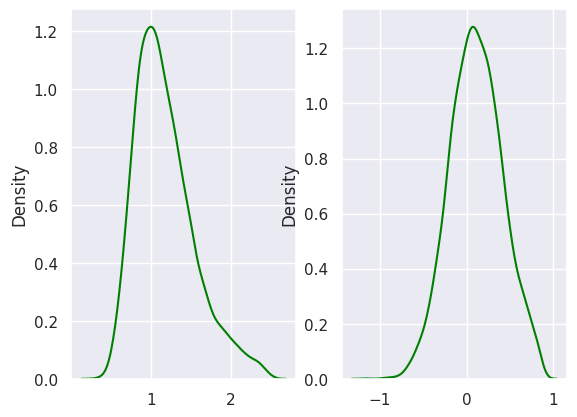

In [62]:
fig, ax = plt.subplots(1, 2)
sns.distplot(ieeg_no_outliers[ieeg_no_outliers['Resp'] != 'No Response']['ReactionTime'].values, hist = False, kde = True,
            label = "Non-Normal", color ="green", ax = ax[0])
 
sns.distplot(fitted_data_, hist = False, kde = True,
            label = "Normal", color ="green", ax = ax[1]);

In [63]:
print(shapiro(fitted_data_))
print(normaltest(fitted_data_))
print(fitted_lambda_)

ShapiroResult(statistic=0.9979177713394165, pvalue=9.88393253464892e-07)
NormaltestResult(statistic=9.729125437778297, pvalue=0.007715201165676336)
-0.08766235398153084


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [64]:
ieeg_no_outliers[ieeg_no_outliers['Resp'] != 'No Response']['stdRT'] = fitted_data_

<ipython-input-64-1ab00667bd79>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ieeg_no_outliers[ieeg_no_outliers['Resp'] != 'No Response']['stdRT'] = fitted_data_


In [65]:
# saving result
ieeg_no_outliers.to_csv(
    Path(working_path).joinpath('ieeg_processed.csv')
)

# EEG dataset

In [ ]:
data_eeg = eeg['Subject'] # contains trials for each of the subjects
print('Number of subjects in EEG dataset is', data_eeg.shape[1])

Number of subjects in EEG dataset is 29


In [ ]:
subjects_eeg = [] # subject numbers
for i in range(0, data_eeg.shape[1]):
  name = data_eeg[0, i]['Name'][0][0][0]
  subjects_eeg.append(name)

In [ ]:
columns_eeg = data_eeg[0, 0]['trialInfo'][0, 0].dtype.names # name of the variables from trial info
final_eeg = pd.DataFrame(columns=columns_eeg)
final_eeg['Trial'] = np.nan
final_eeg['Subject'] = np.nan
for subj in range(0, data_eeg.shape[1]): # for each subject
  print(subj)
  subj_df = get_to_df(data_eeg[0, subj]['trialInfo'][0, 0])
  subj_df['Subject'] = subjects_eeg[subj]
  final_eeg = pd.concat([final_eeg, subj_df], axis = 0)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


In [ ]:
final_eeg.columns

Index(['Trial', 'Subject', 'Block', 'ProbeType', 'ProbeTypeName',
       'StimulusCategory', 'ListenCue', 'ReactionTime', 'KeyCode', 'Response',
       'ResponseCorrect', 'Omission', 'StimulusAudioStart',
       'StimulusAlignedTrigger', 'DelayPeriodOnset', 'MaintenancePeriodOnset',
       'ProbeCueOnset', 'ProbeAudioStart', 'ProbeAlignedTrigger',
       'TriggerValueCondition', 'StimulusSounds_idx', 'StimulusSounds_name',
       'ProbeCategory', 'ProbeSound_idx', 'ProbeSound_name'],
      dtype='object')

#Preprocessing EEG dataset

In [ ]:
'''eeg = pd.read_csv(
    working_path.joinpath('eeg_all.csv'),
    index_col=None
)'''

In [ ]:
eeg = final_eeg.copy()

In [ ]:
eeg.columns

Index(['Trial', 'Subject', 'Block', 'ProbeType', 'ProbeTypeName',
       'StimulusCategory', 'ListenCue', 'ReactionTime', 'KeyCode', 'Response',
       'ResponseCorrect', 'Omission', 'StimulusAudioStart',
       'StimulusAlignedTrigger', 'DelayPeriodOnset', 'MaintenancePeriodOnset',
       'ProbeCueOnset', 'ProbeAudioStart', 'ProbeAlignedTrigger',
       'TriggerValueCondition', 'StimulusSounds_idx', 'StimulusSounds_name',
       'ProbeCategory', 'ProbeSound_idx', 'ProbeSound_name'],
      dtype='object')

In [ ]:
#eeg = eeg.loc[:, eeg.columns != 'Unnamed: 0'] # some extra column appeared while uploading data

In [ ]:
eeg.isnull().sum()

Trial                       0
Subject                     0
Block                       0
ProbeType                   0
ProbeTypeName               0
StimulusCategory            0
ListenCue                   0
ReactionTime              100
KeyCode                     0
Response                    0
ResponseCorrect             0
Omission                    0
StimulusAudioStart          0
StimulusAlignedTrigger      0
DelayPeriodOnset            0
MaintenancePeriodOnset      0
ProbeCueOnset               0
ProbeAudioStart             0
ProbeAlignedTrigger         0
TriggerValueCondition       0
StimulusSounds_idx          0
StimulusSounds_name         0
ProbeCategory               0
ProbeSound_idx              0
ProbeSound_name             0
dtype: int64

In [ ]:
print(len(eeg.Subject.unique()))
print(eeg.shape)

29
(5568, 25)


In [ ]:
eeg_subset = eeg[[
                 'Trial', 'Subject', 'Block', 'ProbeType', 'ProbeSound_idx',
                 'ProbeTypeName', 'StimulusCategory', 'ReactionTime', 'KeyCode',
                 'Response', 'ResponseCorrect', 'Omission', 'ProbeCategory',
                  'StimulusSounds_name', 'ProbeSound_name', 'StimulusSounds_idx'                 
]]

In [ ]:
eeg_subset.head()

,Trial,Subject,Block,ProbeType,ProbeSound_idx,ProbeTypeName,StimulusCategory,ReactionTime,KeyCode,Response,ResponseCorrect,Omission,ProbeCategory,StimulusSounds_name,ProbeSound_name,StimulusSounds_idx
0,0,E2,1,1,21,out_of_sequence,High Words,NaN,2.Left3.Left,No Response,0,No Response,Low Words,"[[mon.wav], [pcn.wav], [sik.wav], [kap.wav], [...",Sur.wav,"[6, 7, 8, 4, 10]"
1,1,E2,1,2,38,in_sequence,Low Non-words,1.282162,2.Left,Yes,1,Responded,Low Non-words,"[[yuf.wav], [JcG.wav], [kuv.wav], [wEz.wav], [...",ycG.wav,"[39, 32, 35, 37, 38]"
2,2,E2,1,2,30,in_sequence,Low Words,0.987854,2.Left,Yes,1,Responded,Low Words,"[[[tub.wav]], [[fcg.wav]], [[f^j.wav]], [[lcG....",yuT.wav,"[[27, 23, 22, 24, 25, 29, 26, 28, 30]]"
3,3,E2,1,2,5,in_sequence,High Words,1.588743,2.Left,Yes,1,Responded,High Words,"[[fEl.wav], [lEr.wav], [sik.wav], [kap.wav], [...",lEr.wav,"[2, 5, 8, 4, 6]"
4,4,E2,1,1,13,out_of_sequence,Low Non-words,1.184043,3.Left,No,1,Responded,High Non-Words,"[[[gWT.wav]], [[kuv.wav]], [[vRn.wav]], [[zRT....",g@n.wav,"[[34, 35, 36, 40, 39, 33, 37]]"


In [ ]:
# check whether any response accuracy is less than 75%
(eeg_subset.groupby(['Subject'])['ResponseCorrect'].mean() < 0.75).any()

False

In [ ]:
eeg_subset.groupby(['Subject'])['ResponseCorrect'].mean()

Subject
E10    0.911458
E11    0.895833
E12    0.859375
E13    0.833333
E15    0.817708
E16    0.890625
E17    0.791667
E18    0.947917
E2     0.875000
E20    0.817708
E21    0.812500
E22    0.833333
E23    0.864583
E24    0.828125
E25    0.833333
E26    0.843750
E27    0.765625
E28    0.901042
E29    0.817708
E3     0.885417
E30    0.885417
E31    0.890625
E33    0.953125
E4     0.791667
E5     0.880208
E6     0.755208
E7     0.864583
E8     0.875000
E9     0.921875
Name: ResponseCorrect, dtype: float64

In [ ]:
whole_list = eeg_subset['StimulusSounds_idx'].values
new_sound_idx = []
for i in whole_list:
  if type(i) is list:
    new_sound_idx.append(i)
  elif type(i) is np.ndarray:
    new_sound_idx.append(i[0].tolist())
  else:
    print(type(i))
    print(len(new_sound_idx))
    break

In [ ]:
eeg_subset['StimulusSounds_idx'] = new_sound_idx

<ipython-input-229-6042217f2404>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eeg_subset['StimulusSounds_idx'] = new_sound_idx


In [ ]:
# checking the length of word lists presented
compare = []
for i in new_sound_idx:
  length = len(i)
  if length not in compare:
    compare.append(length)
print(compare)

[5, 9, 7, 3]


In [ ]:
# calculating relative position of the word in the list
# pos for only in seqence trials: probe sound index and stimulus sound index
# beginning middle or end
positions = [] # for the new 'position' column in df
# 1 - beginning, 2 - middle, 3 - end
ind = eeg_subset['ProbeSound_idx'].values
in_out = eeg_subset['ProbeType'].values
for i in range(0, len(ind)):
  if in_out[i] == 2: # if it is in sequence
    if ind[i] in new_sound_idx[i]:
      # for length of the list 3
      if len(new_sound_idx[i]) == 3:
        if new_sound_idx[i].index(ind[i]) == 0:
          positions.append(1) # beginning 
        elif new_sound_idx[i].index(ind[i]) == 1:
          positions.append(2) # middle
        elif new_sound_idx[i].index(ind[i]) == 2:
          positions.append(3) # end
      
      # for length of the list 5
      ## revise!
      elif len(new_sound_idx[i]) == 5:
        if new_sound_idx[i].index(ind[i]) in [0, 1]:
          positions.append(1) # beginning 
        elif new_sound_idx[i].index(ind[i]) == 2:
          positions.append(2) # middle
        elif new_sound_idx[i].index(ind[i]) in [3, 4]:
          positions.append(3) # end

      # for length of the list 7
      elif len(new_sound_idx[i]) == 7:
        if new_sound_idx[i].index(ind[i]) in [0, 1]:
          positions.append(1) # beginning 
        elif new_sound_idx[i].index(ind[i]) in [2, 3, 4]:
          positions.append(2) # middle
        elif new_sound_idx[i].index(ind[i]) in [5, 6]:
          positions.append(3) # end
      
      # for length of the list 9
      elif len(new_sound_idx[i]) == 9:
        if new_sound_idx[i].index(ind[i]) in [0, 1, 2]:
          positions.append(1) # beginning 
        elif new_sound_idx[i].index(ind[i]) in [3, 4, 5]:
          positions.append(2) # middle
        elif new_sound_idx[i].index(ind[i]) in [6, 7, 8]:
          positions.append(3) # end
    else:
      print('Check', i)
      break  
  elif in_out[i] == 1:
    positions.append(0) # if it is out of sequence it is not in the list
  else:
    print('Check', i)
    break

In [ ]:
length = []
for i in eeg_subset.StimulusSounds_idx:
  length.append(len(i))

In [ ]:
eeg_subset['Position'] = positions
eeg_subset['Length'] = length

<ipython-input-233-25a45b78502a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eeg_subset['Position'] = positions
<ipython-input-233-25a45b78502a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eeg_subset['Length'] = length


In [ ]:
# types in ProbeCategory column differ in case
# here we make them lowrcase
new_probe = []
for i in eeg_subset.ProbeCategory.values:
  new_probe.append(i.lower())
eeg_subset['ProbeCategory'] = new_probe

<ipython-input-234-07ed8a5c37a8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eeg_subset['ProbeCategory'] = new_probe


Standardizing RT

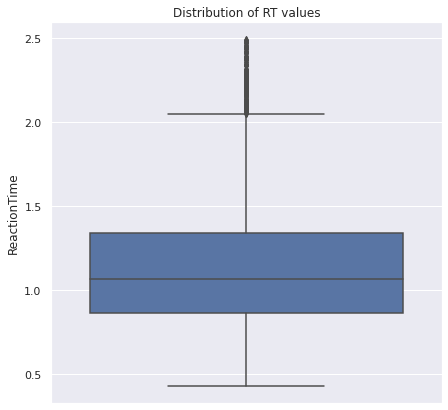

In [ ]:
pl.figure(figsize = (7, 7))
ax = sns.boxplot(y="ReactionTime", data=eeg_subset)
pl.title("Distribution of RT values");

In [ ]:
# check for outliers outside 
eeg_no_outliers = eeg_subset.copy()
q75 = np.percentile(eeg_no_outliers['ReactionTime'], 75)
q25 = np.percentile(eeg_no_outliers['ReactionTime'], 25)
inter_qr = q75 - q25
upper = q75 + (inter_qr*1.5)
lower = q25 - (inter_qr*1.5)
col_new = []
index = 0
for value in eeg_no_outliers['ReactionTime'].values:
  if value < lower:
    col_new.append(np.nan)
    index += 1
  elif value > upper:
    col_new.append(np.nan)
    index += 1
  else:
    col_new.append(value)
print(index)

0


No outliers in the EEG dataset

In [ ]:
# standardization with RT without outliers 
rt = eeg_subset[eeg_subset['Response'] != 'No Response'].ReactionTime.values
rt_mean = rt.mean()
rt_std = rt.std()
newRT = []
for i in eeg_subset.ReactionTime.values:
  if math.isnan(i) == True:
    newRT.append(i)
  else:
    newRT.append((i - rt_mean)/rt_std)

In [ ]:
eeg_subset['stdRT'] = newRT

<ipython-input-238-af2a9f2fc113>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eeg_subset['stdRT'] = newRT


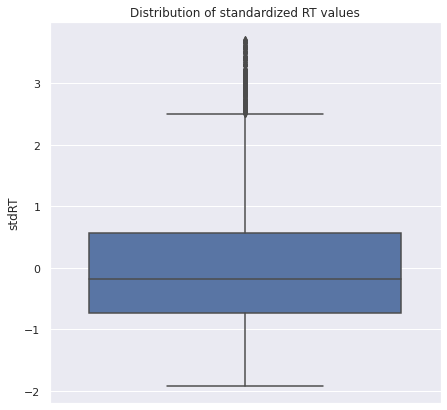

In [ ]:
pl.figure(figsize = (7, 7))
ax = sns.boxplot(y="stdRT", data=eeg_subset)
pl.title("Distribution of standardized RT values");

<Figure size 1440x720 with 0 Axes>

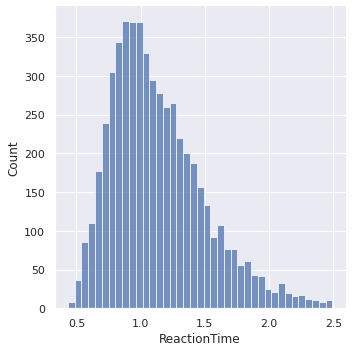

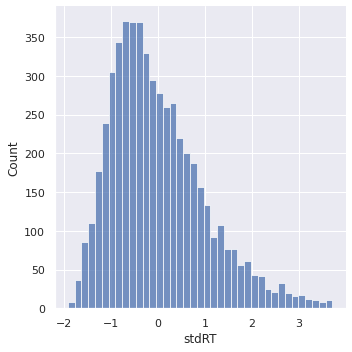

In [ ]:
# upper plot - with outliers, lower plots - without
pl.figure(figsize = (20, 10))
sns.displot(eeg_subset['ReactionTime']);
sns.displot(eeg_subset['stdRT']);

In [ ]:
lex = []
phon = []
for i in eeg_subset.ProbeCategory.values:
  if 'non-words' in i: # non - words = 0, words = 0
    lex.append(0)
  elif 'words' in i:
    lex.append(1)
for i in eeg_subset.ProbeCategory.values:
  if 'low' in i: # low = 1 high = 0
    phon.append(1)
  elif 'high' in i:
    phon.append(0)
print(len(lex))
print(len(phon))

5568
5568


In [ ]:
eeg_subset['Lex'] = lex
eeg_subset['Phono'] = phon

<ipython-input-242-900deb494d65>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eeg_subset['Lex'] = lex
<ipython-input-242-900deb494d65>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eeg_subset['Phono'] = phon


##Stats on EEG

In [ ]:
print(
    'Accuracy without "No response" trials',
    eeg_subset[eeg_subset['Response'] != 'No Response'].ResponseCorrect.mean()
)
print(
    'Accuracy with "No response" trials',
    eeg_subset.ResponseCorrect.mean()
)
    

Accuracy without "No response" trials 0.8723482077542063
Accuracy with "No response" trials 0.8566810344827587


In [ ]:
print('Shape of the dataset with no response trials', eeg_subset.shape)
print('Shape of the dataset without no response trials', eeg_subset[eeg_subset['Response'] != 'No Response'].shape)

Shape of the dataset with no response trials (5568, 21)
Shape of the dataset without no response trials (5468, 21)


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Mean 1.1349431817298263 Max 2.492920639537033 Min 0.43356203194434784


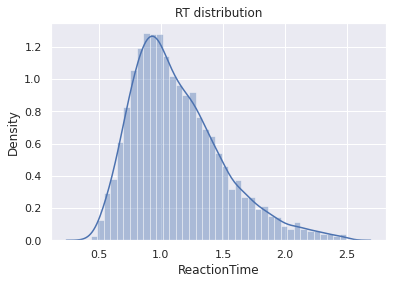

In [ ]:
sns.distplot(eeg_subset[eeg_subset['Response'] != 'No Response'].ReactionTime)
pl.title('RT distribution');
print(
    'Mean', eeg_subset[eeg_subset['Response'] != 'No Response'].ReactionTime.mean(),
    'Max', eeg_subset[eeg_subset['Response'] != 'No Response'].ReactionTime.max(),
    'Min', eeg_subset[eeg_subset['Response'] != 'No Response'].ReactionTime.min()
)

In [ ]:
values = []
for i in eeg_subset[eeg_subset['Response'] != 'No Response'].Subject.unique():
  subset = eeg_subset[eeg_subset['Response'] != 'No Response']
  subset = subset[subset['Subject'] == i]
  q75 = np.percentile(subset['ReactionTime'], 75)
  q25 = np.percentile(subset['ReactionTime'], 25)
  inter_qr = q75 - q25
  upper = q75 + (inter_qr*3)
  lower = q25 - (inter_qr*3)
  index = 0
  for val in subset.ReactionTime.values:
    if val < lower:
      values.append((i, val))
      index += 1
    elif val > upper:
      values.append((i, val))
      index += 1
  print(i, index)

E2 2
E3 0
E4 0
E5 0
E6 3
E7 5
E8 3
E9 7
E10 6
E11 1
E12 1
E13 0
E15 0
E16 2
E17 0
E18 4
E20 1
E21 0
E22 0
E23 2
E24 2
E25 1
E26 0
E27 0
E28 0
E29 0
E30 0
E31 0
E33 7


In [ ]:
len(values)

47

In [ ]:
# check for normality of the distribution
test = shapiro(eeg_subset[eeg_subset['Response'] != 'No Response']['ReactionTime'].values)
if test[1] > 0.05:
  print('Probably Gaussian')
else:
  print('Probably not Gaussian')

Probably not Gaussian


/usr/local/lib/python3.8/dist-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [ ]:
normaltest(eeg_subset[eeg_subset['Response'] != 'No Response']['ReactionTime'].values)

NormaltestResult(statistic=619.6311037347008, pvalue=2.8107059705027285e-135)

In [ ]:
fitted_data, fitted_lambda = boxcox(eeg_subset[eeg_subset['Response'] != 'No Response']['ReactionTime'].values)

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


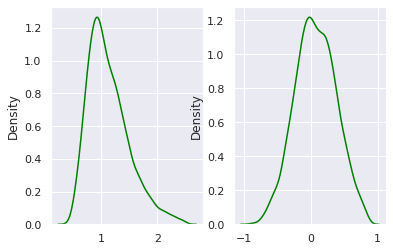

In [ ]:
fig, ax = pl.subplots(1, 2)
sns.distplot(eeg_subset[eeg_subset['Response'] != 'No Response']['ReactionTime'].values, hist = False, kde = True,
            label = "Non-Normal", color ="green", ax = ax[0])
 
sns.distplot(fitted_data, hist = False, kde = True,
            label = "Normal", color ="green", ax = ax[1]);

In [ ]:
eeg_subset[eeg_subset['Response'] != 'No Response']['stdRT'] = fitted_data

<ipython-input-252-beae636ae5d4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eeg_subset[eeg_subset['Response'] != 'No Response']['stdRT'] = fitted_data


In [ ]:
print(fitted_lambda)
print('Shapiro test:', shapiro(fitted_data))
print('Other normal test:', normaltest(fitted_data))

-0.14836812286618403
Shapiro test: ShapiroResult(statistic=0.9975175857543945, pvalue=8.745944057864108e-08)
Other normal test: NormaltestResult(statistic=39.477175381694096, pvalue=2.6769501589031745e-09)


/usr/local/lib/python3.8/dist-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


'No Response' trials are coded as incorrect in the data already, so we don't need to recode this.

In [ ]:
# saving result
eeg_subset.to_csv(
    Path(working_path).joinpath('eeg_processed.csv')
)